**Import Libraries**

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
import warnings
warnings.filterwarnings('ignore')

**Load Data**

In [11]:
dataset = read_csv('dow.csv',index_col=0)
print(dataset.shape)
#4804 dates, 30 stocks
set_option('display.width', 100)
dataset.head(5)

(4804, 30)


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,NaN,...,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,NaN,...,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,NaN,...,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,NaN,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,NaN,...,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,NaN,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,NaN,...,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,NaN,48.535033,21.051805


**Data Cleaning**

In [26]:
missing = dataset.isnull().mean().sort_values(ascending=False)
print(missing)
drop_list = sorted(list(missing[missing > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)

# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

# Drop the rows containing NA
dataset= dataset.dropna(axis=0)
print(dataset.shape)

# Daily Linear Returns (%)
datareturns = dataset.pct_change(1)

#Keep data within 3 standard deviation
datareturns = datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

MMM     0.0
AXP     0.0
WMT     0.0
VZ      0.0
UNH     0.0
UTX     0.0
TRV     0.0
PG      0.0
PFE     0.0
NKE     0.0
MSFT    0.0
MRK     0.0
MCD     0.0
JPM     0.0
JNJ     0.0
INTC    0.0
IBM     0.0
HD      0.0
GS      0.0
XOM     0.0
DIS     0.0
KO      0.0
CSCO    0.0
CVX     0.0
CAT     0.0
BA      0.0
AAPL    0.0
WBA     0.0
dtype: float64
(4804, 28)


In [25]:
dataset.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,23.862240,...,38.135101,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,23.405167,...,36.846046,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,24.569179,...,37.235380,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,25.958680,...,35.988857,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,25.882501,...,36.459983,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,48.535033,21.051805


In [27]:
datareturns.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-0.017595,0.009056,-0.051151,-0.015793,-0.015710,-0.009331,-0.030055,0.034008,0.010312,0.011940,...,-0.025657,0.050113,-0.001742,0.016393,-0.011299,-0.023209,0.002158,-0.009402,-0.014870,0.039649
2000-01-20,-0.037243,0.016790,0.065128,-0.023725,-0.044210,-0.005003,0.000890,0.009655,-0.032230,-0.021856,...,-0.009346,-0.023670,-0.016486,-0.024263,-0.005486,-0.022739,0.025210,0.003123,-0.010615,0.000000
2000-02-02,-0.017316,-0.028402,-0.014364,0.020114,0.005788,-0.006732,-0.033107,-0.030105,0.034722,0.007453,...,-0.020692,0.016063,-0.027027,-0.008744,-0.048789,0.001118,0.026451,-0.004197,-0.005282,0.004512
2000-02-03,-0.008757,-0.007917,0.045542,-0.026664,-0.026013,-0.014402,0.034241,-0.020043,0.016913,-0.017062,...,0.027874,0.009275,-0.010278,-0.008314,-0.044835,-0.015070,-0.008948,-0.014669,0.000000,-0.002073
2000-02-04,-0.028684,-0.009208,0.045397,0.012891,0.000000,-0.035363,0.028014,0.018100,0.006600,-0.018208,...,0.028373,-0.024854,0.003368,-0.031285,0.004506,-0.029467,0.024738,0.002053,-0.035457,0.010734


**Standardization (mean = 0, var = 1)**

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-1.713383,0.565603,-2.707674,-1.133045,-1.041247,-0.787063,-1.834413,3.568833,0.725353,0.981056,...,-1.936268,3.666524,-0.172523,1.771791,-0.936081,-1.954189,0.076018,-0.836288,-1.374665,2.942150
2000-01-20,-3.564118,1.077343,3.304005,-1.670108,-2.833568,-0.445782,0.021934,0.987042,-2.415069,-1.897394,...,-0.733208,-1.816361,-1.420880,-2.741513,-0.475716,-1.915682,1.653794,0.241016,-0.987037,-0.035748
2000-02-02,-1.687118,-1.912847,-0.805771,1.298353,0.310731,-0.582071,-2.017516,-3.228199,2.527273,0.598855,...,-1.570041,1.136259,-2.313315,-1.018676,-3.904924,0.036634,1.738736,-0.388661,-0.501179,0.303155
2000-02-03,-0.880834,-0.557421,2.291412,-1.869126,-1.689184,-1.186951,2.022552,-2.161418,1.212601,-1.489120,...,2.012015,0.631795,-0.895207,-0.970962,-3.591816,-1.288092,-0.684070,-1.289310,-0.019975,-0.191463
2000-02-04,-2.757847,-0.642837,2.283936,0.809265,-0.053288,-2.840078,1.649006,1.882288,0.451311,-1.586717,...,2.048796,-1.904348,0.260134,-3.520991,0.315593,-2.466351,1.621495,0.148985,-3.250242,0.770448


In [29]:
set_option('precision', 3)
rescaledDataset.describe()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
count,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,...,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3892.000,3.892e+03,3.892e+03,3.892e+03
mean,-2.373e-17,9.128e-18,4.564e-18,-1.369e-17,-2.328e-17,1.369e-17,2.191e-17,-2.465e-17,-2.191e-17,-2.465e-17,...,3.104e-17,2.191e-17,5.477e-18,-1.187e-17,-2.099e-17,-1.826e-17,0.000,-1.826e-18,-1.095e-17,1.095e-17
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,...,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000,1.000e+00,1.000e+00,1.000e+00
min,-3.924e+00,-4.357e+00,-3.726e+00,-3.698e+00,-3.688e+00,-3.796e+00,-4.359e+00,-4.013e+00,-4.054e+00,-3.821e+00,...,-4.228e+00,-3.940e+00,-3.900e+00,-4.096e+00,-4.302e+00,-3.814e+00,-3.964,-3.993e+00,-3.998e+00,-3.807e+00
25%,-5.513e-01,-4.935e-01,-5.312e-01,-5.965e-01,-5.685e-01,-5.927e-01,-4.946e-01,-5.581e-01,-5.459e-01,-5.930e-01,...,-5.606e-01,-5.735e-01,-5.639e-01,-5.583e-01,-5.452e-01,-5.682e-01,-0.562,-5.844e-01,-5.611e-01,-5.998e-01
50%,1.367e-03,-7.736e-03,-2.331e-02,-1.092e-02,-1.676e-02,1.636e-02,2.489e-03,9.481e-03,1.870e-03,-1.357e-02,...,-2.632e-02,-1.473e-02,-2.502e-02,-1.429e-02,-4.608e-04,-1.033e-02,-0.017,1.146e-02,2.637e-04,-2.222e-02
75%,5.882e-01,5.269e-01,5.397e-01,6.064e-01,5.788e-01,6.062e-01,5.403e-01,5.580e-01,5.583e-01,5.962e-01,...,5.520e-01,5.539e-01,5.648e-01,5.458e-01,5.461e-01,5.624e-01,0.562,5.786e-01,5.573e-01,5.889e-01
max,3.949e+00,4.324e+00,3.924e+00,3.803e+00,3.808e+00,3.714e+00,4.320e+00,4.044e+00,4.043e+00,3.721e+00,...,4.127e+00,4.057e+00,3.870e+00,4.172e+00,4.317e+00,3.982e+00,4.003,3.753e+00,4.100e+00,3.757e+00


**Train Test Split 80-20**

In [30]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.8)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = rescaledDataset.columns.values
print(stock_tickers)
n_tickers = len(stock_tickers)

['MMM' 'AXP' 'AAPL' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GS' 'HD'
 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'TRV' 'UTX'
 'UNH' 'VZ' 'WMT' 'WBA']


**PCA**

In [31]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)

print(pca.components_[0])

[-0.2278224  -0.22835766 -0.15302828 -0.18969933 -0.20200012 -0.17810558
 -0.19508121 -0.16845303 -0.20820442 -0.19308548 -0.20879404 -0.20231768
 -0.19939638 -0.19521427 -0.16686975 -0.22806024 -0.15153408 -0.169941
 -0.19367262 -0.17118841 -0.18993347 -0.16805969 -0.197612   -0.22658993
 -0.13821257 -0.16688803 -0.16897835 -0.16070821]


**Explained Variance**

,Explained Variance
0,37.03%
1,42.75%
2,47.10%
3,51.08%
4,54.60%
5,57.74%
6,60.65%
7,63.44%
8,66.18%
9,68.71%


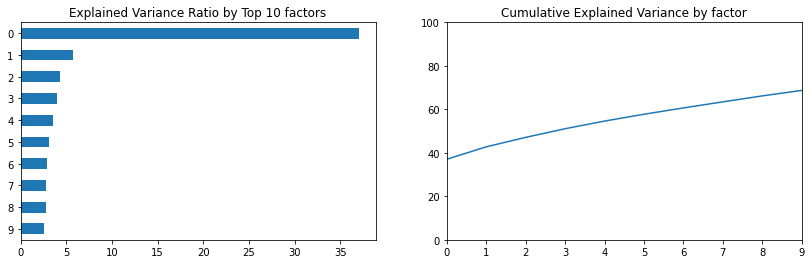

In [32]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

**Portfolio Weights**

In [45]:
weights = pd.DataFrame()
print(pca.components_[0])
print(sum(pca.components_[0]))
for i in range(len(pca.components_)):
  weights[i] = pca.components_[i] / sum(pca.components_[i])

weights

[-0.2278224  -0.22835766 -0.15302828 -0.18969933 -0.20200012 -0.17810558
 -0.19508121 -0.16845303 -0.20820442 -0.19308548 -0.20879404 -0.20231768
 -0.19939638 -0.19521427 -0.16686975 -0.22806024 -0.15153408 -0.169941
 -0.19367262 -0.17118841 -0.18993347 -0.16805969 -0.197612   -0.22658993
 -0.13821257 -0.16688803 -0.16897835 -0.16070821]
-5.247808242068631


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.043,0.083,-0.646,-0.083,0.800,0.279,0.214,-0.832,-0.628,-0.565,...,28.169,-0.605,-0.433,-1.008,4.019,-9.134,-4.933,12.691,-0.524,-0.029
1,0.044,-0.315,-0.036,-1.196,-1.098,-0.606,0.103,0.358,0.753,0.368,...,-1.362,0.815,-3.826,-1.540,-29.883,-6.054,1.086,-1.645,4.638,0.213
2,0.029,-1.149,0.263,1.173,0.290,0.759,1.324,0.525,2.639,8.587,...,16.907,1.173,-1.044,0.189,1.319,0.424,-0.287,-0.379,-1.477,-0.047
3,0.036,-0.043,-0.780,-0.504,1.030,0.415,2.653,-1.831,-1.655,0.533,...,-40.318,5.249,-0.042,0.209,0.639,-5.453,1.558,8.953,0.224,0.300
4,0.038,-0.292,-1.338,-0.178,0.947,0.126,-0.281,-0.812,-0.240,0.513,...,21.385,-0.471,2.245,1.109,-2.528,3.679,5.228,2.330,0.253,-0.472
5,0.034,0.443,-2.483,0.876,0.305,-0.497,-2.297,0.601,1.212,-0.159,...,-4.888,-0.525,-0.060,0.080,-0.935,0.347,-0.212,-0.668,-0.334,9.511
6,0.037,-1.235,0.593,0.906,-0.306,0.137,0.955,-0.148,-0.058,-1.397,...,-12.925,0.242,1.504,-0.512,-11.431,12.479,-0.049,8.278,0.070,-0.213
7,0.032,0.849,0.634,0.604,0.872,-0.953,2.035,1.109,-2.249,-0.117,...,16.985,4.297,0.691,-0.687,1.570,2.054,-0.235,1.458,0.762,0.558
8,0.040,-0.313,0.262,-0.232,-0.075,-0.386,0.610,-0.822,0.262,-8.541,...,28.061,-3.458,0.905,0.887,4.098,-2.052,0.904,-3.605,-0.887,-0.368
9,0.037,0.518,-2.259,1.012,0.306,-0.711,-2.516,0.769,0.820,-0.488,...,-8.282,0.422,-0.415,0.130,-0.892,-1.139,-0.272,-0.237,0.815,-9.400


In [49]:
NumComponents=5
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=dataset.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T
#.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=True, sharey=True, ylim= (-1,1))

,Portfolio 0,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4
MMM,0.043,0.083,-0.646,-0.083,0.800
AXP,0.044,-0.315,-0.036,-1.196,-1.098
AAPL,0.029,-1.149,0.263,1.173,0.290
BA,0.036,-0.043,-0.780,-0.504,1.030
CAT,0.038,-0.292,-1.338,-0.178,0.947
CVX,0.034,0.443,-2.483,0.876,0.305
CSCO,0.037,-1.235,0.593,0.906,-0.306
KO,0.032,0.849,0.634,0.604,0.872
DIS,0.040,-0.313,0.262,-0.232,-0.075
XOM,0.037,0.518,-2.259,1.012,0.306


**Sharpe Ratio**

In [60]:
# Sharpe Ratio
def sharpe_ratio(df, days_per_year=252):
  year = df.shape[0]/days_per_year

  annualized_return = np.power(np.prod(1+df),(1/year))-1

  annualized_vol = df.std() * np.sqrt(days_per_year)

  annualized_sharpe = annualized_return / annualized_vol

  return (annualized_return, annualized_vol, annualized_sharpe)
sharpe_ratio(datareturns)

(MMM     0.145
 AXP     0.104
 AAPL    0.298
 BA      0.233
 CAT     0.199
 CVX     0.154
 CSCO    0.102
 KO      0.079
 DIS     0.104
 XOM     0.093
 GS      0.055
 HD      0.103
 IBM     0.128
 INTC    0.056
 JNJ     0.082
 JPM     0.046
 MCD     0.157
 MRK     0.118
 MSFT    0.135
 NKE     0.188
 PFE     0.059
 PG      0.104
 TRV     0.118
 UTX     0.162
 UNH     0.267
 VZ      0.066
 WMT     0.041
 WBA     0.103
 dtype: float64, MMM     0.169
 AXP     0.240
 AAPL    0.307
 BA      0.234
 CAT     0.252
 CVX     0.201
 CSCO    0.265
 KO      0.150
 DIS     0.215
 XOM     0.186
 GS      0.260
 HD      0.227
 IBM     0.182
 INTC    0.268
 JNJ     0.140
 JPM     0.260
 MCD     0.171
 MRK     0.194
 MSFT    0.215
 NKE     0.214
 PFE     0.188
 PG      0.143
 TRV     0.200
 UTX     0.194
 UNH     0.232
 VZ      0.185
 WMT     0.174
 WBA     0.211
 dtype: float64, MMM     0.861
 AXP     0.434
 AAPL    0.969
 BA      0.993
 CAT     0.789
 CVX     0.765
 CSCO    0.386
 KO      0.525
 DIS    